# Convolutional Neural Networks (CNN)

In this notebook, we first run a simple baseline CNN. We notice that the model is slightly overfitting, achieving nearly 100% training accuracy. So, we attempt several implementation to reduce the complexity of the model.

In [1]:
# Necessary Imports

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Plotting learning curves
def plot_accuracy(model, history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

In [3]:
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')

X_train = train.drop(columns = 'label')
X_test = test.drop(columns = 'label')

# Check that data is input properly - pixel values in range 0-255
column_val = 'pixel{value}'
for i in range(1, 785):
    if (X_train[column_val.format(value=i)] < 0).any() or (X_train[column_val.format(value=i)] > 255).any():
        print("Unexpected value encountered in training data pixel column {value}".format(value=i))
    if (X_test[column_val.format(value=i)] < 0).any() or (X_test[column_val.format(value=i)] > 255).any():
        print("Unexpected value encountered in testing data pixel column {value}".format(value=i))
print("If this is the only message, then all data is good to go!")

# Normalize the data
X_train /= 255.0
X_test /= 255.0

# Reshape to be compatible with input layer
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

# Get target classes
y_train = train['label']
y_test = test['label']

If this is the only message, then all data is good to go!


## Model 1: Baseline

A baseline model is run to get an idea of the achievable accuracy from a simple neural network, not paying too much attention to the number or makeup of the layers.

In [4]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(25))
model_1.summary()

2022-06-10 14:58:09.572779: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-10 14:58:09.576986: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [5]:
model_1.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])
history_1 = model_1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

2022-06-10 14:58:10.696740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
858/858 [==============================] - 31s 35ms/step - loss: 1.9495 - accuracy: 0.4128 - val_loss: 0.4128 - val_accuracy: 0.8731
Epoch 2/10
858/858 [==============================] - 31s 37ms/step - loss: 0.1229 - accuracy: 0.9661 - val_loss: 0.3215 - val_accuracy: 0.9166
Epoch 3/10
858/858 [==============================] - 28s 33ms/step - loss: 0.0289 - accuracy: 0.9925 - val_loss: 0.3966 - val_accuracy: 0.9070
Epoch 4/10
858/858 [==============================] - 37s 43ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.3511 - val_accuracy: 0.9228
Epoch 5/10
858/858 [==============================] - 31s 36ms/step - loss: 0.0176 - accuracy: 0.9955 - val_loss: 0.3270 - val_accuracy: 0.9325
Epoch 6/10
858/858 [==============================] - 29s 34ms/step - loss: 3.3740e-04 - accuracy: 1.0000 - val_loss: 0.3590 - val_accuracy: 0.9279
Epoch 7/10
858/858 [==============================] - 27s 32ms/step - loss: 1.9330e-04 - accuracy: 1.0000 - val_loss: 0.3640 - val_a

Testing Loss: 0.3957881033420563
Testing Accuracy: 0.9323759078979492
Training Accuracy: 1.0


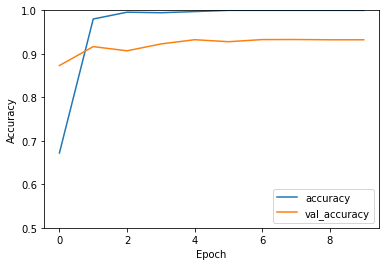

In [6]:
test_loss1, test_acc1 = model_1.evaluate(X_test,  y_test, verbose = 0)
training_acc1 = history_1.history['accuracy'][-1]
print('Testing Loss: {}\nTesting Accuracy: {}\nTraining Accuracy: {}'.format(test_loss1, test_acc1, training_acc1))
plot_accuracy(model_1, history_1)

## Model 2: L2 Regularization

L2 regularization is applied to the Convolutional2D layers. 

It is clear that when applying l2 regularization, training is much slower. Here, a learning rate of 0.005 is used and the training learning curve plateaus at around 20 epochs. When using the default learning rate of 0.01 here, the learning curves are still gradually increasing after 100 epochs. There may be some promise here, but in consideration of time, there are likely more efficient methods. 

In [7]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.005)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.005)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
model_2.add(layers.Dense(25, kernel_regularizer='l2'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [8]:
model_2.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])
history_2 = model_2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
858/858 [==============================] - 26s 29ms/step - loss: 3.5499 - accuracy: 0.0453 - val_loss: 3.2159 - val_accuracy: 0.0229
Epoch 2/100
858/858 [==============================] - 25s 29ms/step - loss: 3.1934 - accuracy: 0.0461 - val_loss: 3.2022 - val_accuracy: 0.0357
Epoch 3/100
858/858 [==============================] - 24s 28ms/step - loss: 3.1856 - accuracy: 0.0474 - val_loss: 3.2141 - val_accuracy: 0.0201
Epoch 4/100
858/858 [==============================] - 29s 33ms/step - loss: 3.1815 - accuracy: 0.0485 - val_loss: 3.2036 - val_accuracy: 0.0301
Epoch 5/100
858/858 [==============================] - 25s 29ms/step - loss: 3.1773 - accuracy: 0.0524 - val_loss: 3.1878 - val_accuracy: 0.0396
Epoch 6/100
858/858 [==============================] - 26s 30ms/step - loss: 3.0568 - accuracy: 0.0845 - val_loss: 2.7584 - val_accuracy: 0.1358
Epoch 7/100
858/858 [==============================] - 26s 30ms/step - loss: 2.4900 - accuracy: 0.2022 - val_loss: 2.3311 - val_ac

Testing Loss: 1.8365205526351929
Testing Accuracy: 0.6491913199424744
Training Accuracy: 0.9569477438926697


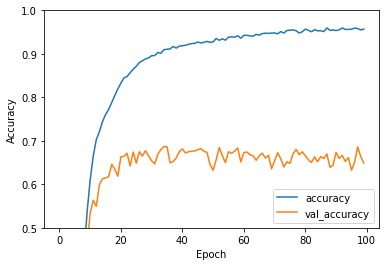

In [9]:
test_loss2, test_acc2 = model_2.evaluate(X_test,  y_test, verbose = 0)
training_acc2 = history_2.history['accuracy'][-1]
print('Testing Loss: {}\nTesting Accuracy: {}\nTraining Accuracy: {}'.format(test_loss2, test_acc2, training_acc2))
plot_accuracy(model_2, history_2)

## Model 3: Dropout Layers
After Conv2D Layers

Dropout layers reduces the complexity of the neural network by randomly terminating a specified proportion of nodes. Here, 20% of the nodes are removed after the 2nd and 3rd Conv2D layers. 

In [10]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.Dropout(0.2))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(25))
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 64)         

In [11]:
model_3.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])
history_3 = model_3.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
858/858 [==============================] - 25s 28ms/step - loss: 1.9316 - accuracy: 0.4163 - val_loss: 0.4036 - val_accuracy: 0.8654
Epoch 2/10
858/858 [==============================] - 23s 27ms/step - loss: 0.1819 - accuracy: 0.9396 - val_loss: 0.2781 - val_accuracy: 0.9292
Epoch 3/10
858/858 [==============================] - 25s 29ms/step - loss: 0.0576 - accuracy: 0.9818 - val_loss: 0.2310 - val_accuracy: 0.9343
Epoch 4/10
858/858 [==============================] - 24s 28ms/step - loss: 0.0368 - accuracy: 0.9888 - val_loss: 0.2884 - val_accuracy: 0.9229
Epoch 5/10
858/858 [==============================] - 24s 28ms/step - loss: 0.0244 - accuracy: 0.9926 - val_loss: 0.2756 - val_accuracy: 0.9276
Epoch 6/10
858/858 [==============================] - 23s 27ms/step - loss: 0.0240 - accuracy: 0.9927 - val_loss: 0.2835 - val_accuracy: 0.9315
Epoch 7/10
858/858 [==============================] - 24s 28ms/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.2519 - val_accuracy:

Testing Loss: 0.2712484896183014
Testing Accuracy: 0.9452035427093506
Training Accuracy: 0.9951556921005249


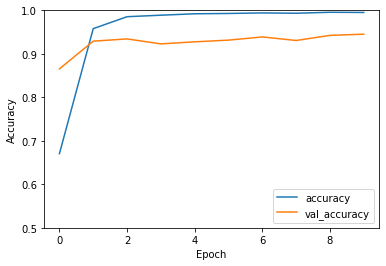

In [12]:
test_loss3, test_acc3 = model_3.evaluate(X_test,  y_test, verbose = 0)
training_acc3 = history_3.history['accuracy'][-1]
print('Testing Loss: {}\nTesting Accuracy: {}\nTraining Accuracy: {}'.format(test_loss3, test_acc3, training_acc3))
plot_accuracy(model_3, history_3)

## Model 4: Weight Initialization

Using the `he_normal` weight initialization, the training accuracy approaches 100% in just three iterations. A different approach would be better. 

In [13]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer= 'he_normal', input_shape=(28, 28, 1)))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dense(25))
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [14]:
model_4.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])
history_4 = model_4.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
858/858 [==============================] - 21s 24ms/step - loss: 1.8350 - accuracy: 0.4416 - val_loss: 0.5707 - val_accuracy: 0.7909
Epoch 2/10
858/858 [==============================] - 21s 24ms/step - loss: 0.1615 - accuracy: 0.9519 - val_loss: 0.4549 - val_accuracy: 0.8809
Epoch 3/10
858/858 [==============================] - 20s 24ms/step - loss: 0.0303 - accuracy: 0.9942 - val_loss: 0.5112 - val_accuracy: 0.8759
Epoch 4/10
858/858 [==============================] - 20s 24ms/step - loss: 0.0233 - accuracy: 0.9942 - val_loss: 0.5161 - val_accuracy: 0.8935
Epoch 5/10
858/858 [==============================] - 20s 24ms/step - loss: 0.0139 - accuracy: 0.9961 - val_loss: 0.5812 - val_accuracy: 0.8873
Epoch 6/10
858/858 [==============================] - 21s 24ms/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.6354 - val_accuracy: 0.9009
Epoch 7/10
858/858 [==============================] - 20s 24ms/step - loss: 3.9252e-04 - accuracy: 1.0000 - val_loss: 0.6065 - val_accur

Testing Loss: 0.5260305404663086
Testing Accuracy: 0.9228945970535278
Training Accuracy: 1.0


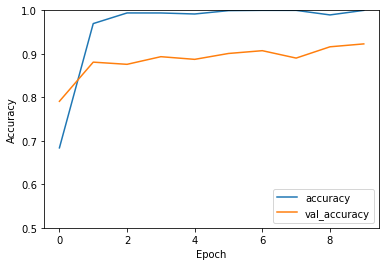

In [15]:
test_loss4, test_acc4 = model_4.evaluate(X_test,  y_test, verbose = 0)
training_acc4 = history_4.history['accuracy'][-1]
print('Testing Loss: {}\nTesting Accuracy: {}\nTraining Accuracy: {}'.format(test_loss4, test_acc4, training_acc4))
plot_accuracy(model_4, history_4)

## Model 5: Dropout
After MaxPooling

The addition of dropout layers appeared to be a promising approach. Other articles online indicated that placement of Dropout layers after MaxPooling is also effective. This is applied here, along with the addition of another Conv2D -> MaxPooling. The testing accuracy here is the best so far at 94.8 %, while the training accuracy is at 96.9%. This appears to generalize better being less complex than the baseline model which reached a 100% training accuracy.

In [16]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.Flatten())
model_5.add(layers.Dense(64, activation='relu'))
model_5.add(layers.Dense(25))
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)         

In [17]:
model_5.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])
history_5 = model_5.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
858/858 [==============================] - 22s 25ms/step - loss: 2.7374 - accuracy: 0.1673 - val_loss: 1.0371 - val_accuracy: 0.6588
Epoch 2/10
858/858 [==============================] - 21s 24ms/step - loss: 0.9639 - accuracy: 0.6626 - val_loss: 0.5417 - val_accuracy: 0.8256
Epoch 3/10
858/858 [==============================] - 21s 24ms/step - loss: 0.5802 - accuracy: 0.7937 - val_loss: 0.4089 - val_accuracy: 0.8660
Epoch 4/10
858/858 [==============================] - 21s 24ms/step - loss: 0.4018 - accuracy: 0.8618 - val_loss: 0.3391 - val_accuracy: 0.8904
Epoch 5/10
858/858 [==============================] - 21s 25ms/step - loss: 0.2946 - accuracy: 0.8979 - val_loss: 0.3192 - val_accuracy: 0.9055
Epoch 6/10
858/858 [==============================] - 21s 24ms/step - loss: 0.2338 - accuracy: 0.9206 - val_loss: 0.3170 - val_accuracy: 0.9016
Epoch 7/10
858/858 [==============================] - 20s 23ms/step - loss: 0.1963 - accuracy: 0.9337 - val_loss: 0.2471 - val_accuracy:

Testing Loss: 0.2126093953847885
Testing Accuracy: 0.9304238557815552
Training Accuracy: 0.9617920517921448


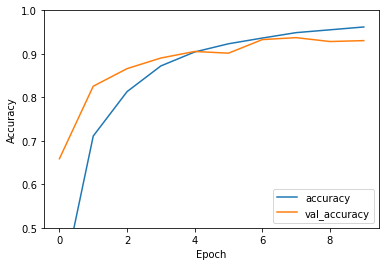

In [18]:
test_loss5, test_acc5 = model_5.evaluate(X_test,  y_test, verbose = 0)
training_acc5 = history_5.history['accuracy'][-1]
print('Testing Loss: {}\nTesting Accuracy: {}\nTraining Accuracy: {}'.format(test_loss5, test_acc5, training_acc5))
plot_accuracy(model_5, history_5)

In [19]:
training_acc = [training_acc1, training_acc2, training_acc3, training_acc4, training_acc5]
testing_acc = [test_acc1, test_acc2, test_acc3, test_acc4, test_acc5]
testing_loss = [test_loss1, test_loss2, test_loss3, test_loss4, test_loss5]
index = ['Baseline', 'l2 Regularization', 'Dropout Layers', 'Weight Initialization', 'Dropout + More Layers']

results_dict = {'Training Accuracy': training_acc, 'Testing Accuracy': testing_acc, 'Testing Loss': testing_loss}
results = pd.DataFrame(results_dict, index = index)
results

,Training Accuracy,Testing Accuracy,Testing Loss
Baseline,1.000000,0.932376,0.395788
l2 Regularization,0.956948,0.649191,1.836521
Dropout Layers,0.995156,0.945204,0.271248
Weight Initialization,1.000000,0.922895,0.526031
Dropout + More Layers,0.961792,0.930424,0.212609


##